In [12]:
# packages
library(fpp3)
library(tibble)
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)
library(tsibbledata)
library(feasts)
library(ggfortify)
library(forecast)
library(gridExtra)
library(tidyverse)

library(ggplot2) # visualisation
library(scales) # visualisation
library(patchwork) # visualisation
library(RColorBrewer) # visualisation
library(corrplot) # visualisation
library(dplyr) # data manipulation
library(readr) # input/output
library(vroom) # input/output
library(skimr) # overview
library(tibble) # data wrangling
library(tidyr) # data wrangling
library(purrr) # data wrangling
library(stringr) # string manipulation
library(forcats) # factor manipulation
library(fuzzyjoin) # data wrangling
library(alluvial) # visualisation
library(ggrepel) # visualisation
library(ggforce) # visualisation
library(ggridges) # visualisation
library(gganimate) # animations
library(GGally) # visualisation
library(ggthemes) # visualisation
library(wesanderson) # visualisation
# library(kableExtra) # display
library(timetk)
library(lubridate)
library(forecast)
library(crosstalk)
library(plotly)
library(foreach)
library(doParallel)

In [13]:
train <- read_csv("train.csv", 
                  col_types = cols(date = col_date(format = "%m/%d/%Y")))  %>% as_tsibble(index=date)

sales_train <- read_csv('sales_train_validation_afcs2021.csv')


Rows: 823 Columns: 1914

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (1): id
dbl (1913): d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9, d_10, d_11, d_12, d...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Plot variable not specified, automatically selected `.vars = FOODS_3_191_TX_3_validation`



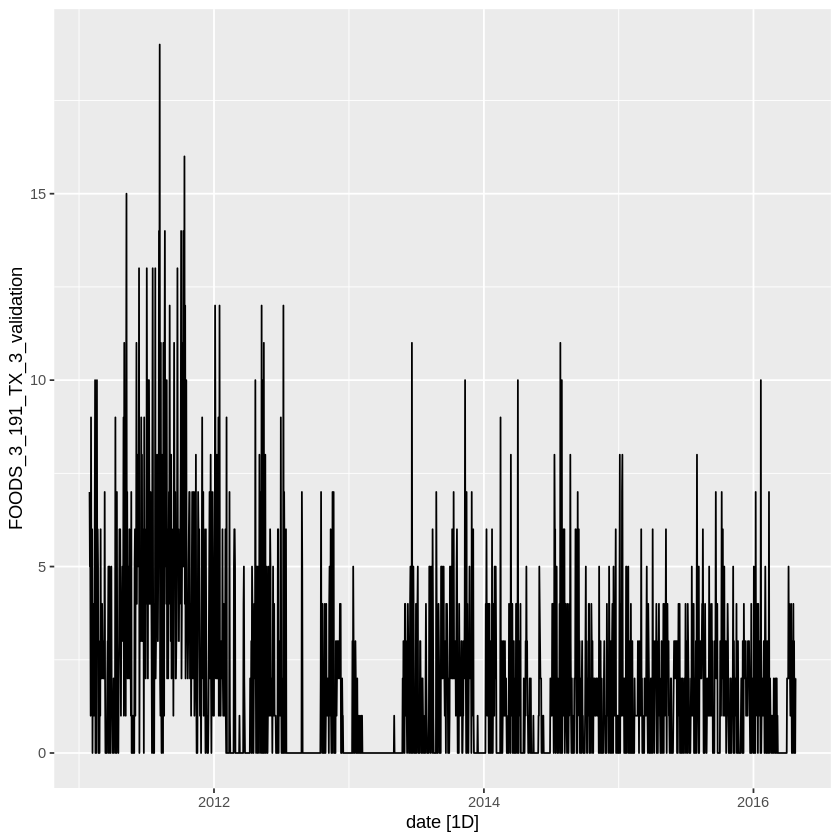

In [14]:
train  %>%  select(date, FOODS_3_191_TX_3_validation)  %>% autoplot()

In [15]:
# cleaning the sales_train_validation TS
extract_ts <- function(df){' function to load the data'
  
  min_date <- date("2011-01-29")
  
  df %>%
    select(id, starts_with("d_")) %>%  
    pivot_longer(starts_with("d_"), names_to = "dates", values_to = "sales") %>%
    mutate(dates = as.integer(str_remove(dates, "d_"))) %>% 
    mutate(dates = min_date + dates - 1) %>% 
    mutate(id = str_remove(id, "_validation"))


}

# Specifying the number of random TS
set.seed(4321)
foo <- sales_train %>% 
  sample_n(5)

# clean/transform table
sales <- extract_ts(foo)

# creating a color per TS
cols <- sales %>% 
  distinct(id) %>% 
  mutate(cols = rep_len(brewer.pal(7, "Set2"), length.out = n_distinct(sales$id)))

sales <- sales %>% 
  left_join(cols, by = "id")

# names of the TS and corresponding color
pal <- cols$cols %>%
   setNames(cols$id)


In [16]:
# plot the subset of time series 
plot_1 <- sales %>% 
  ggplot(aes(dates, sales, col = id, group = id, alpha=0.2)) +
  geom_line()+
    labs(x = "Time", 
         y= "Number of sales",
         title = "Number of individual sales")+
         theme_bw()

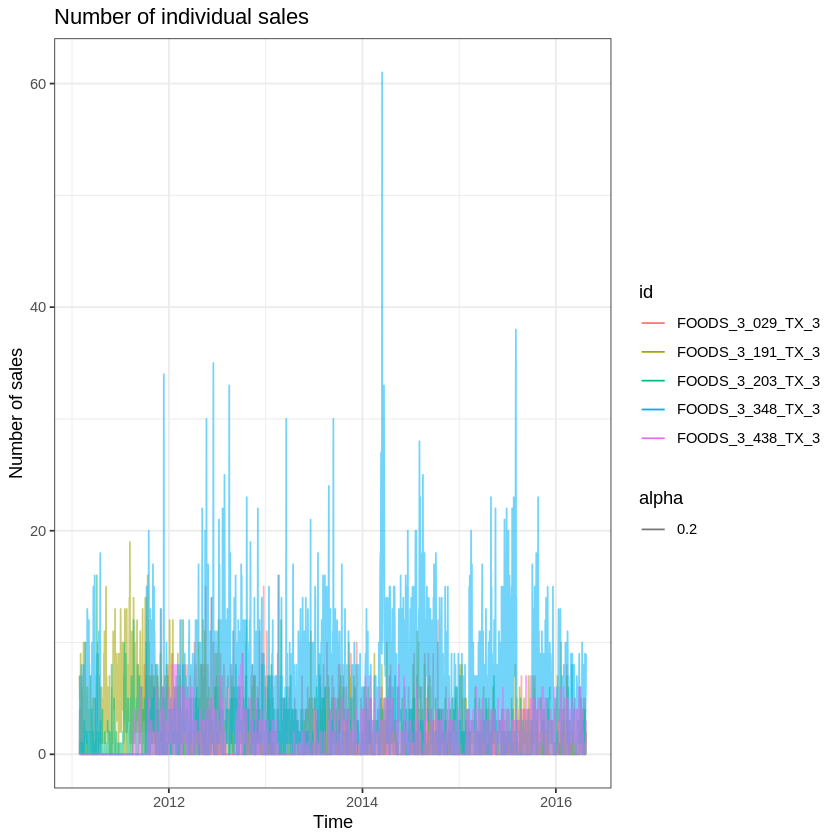

In [17]:
plot_1

Using `dates` as index variable.

Plot variable not specified, automatically selected `y = sales`



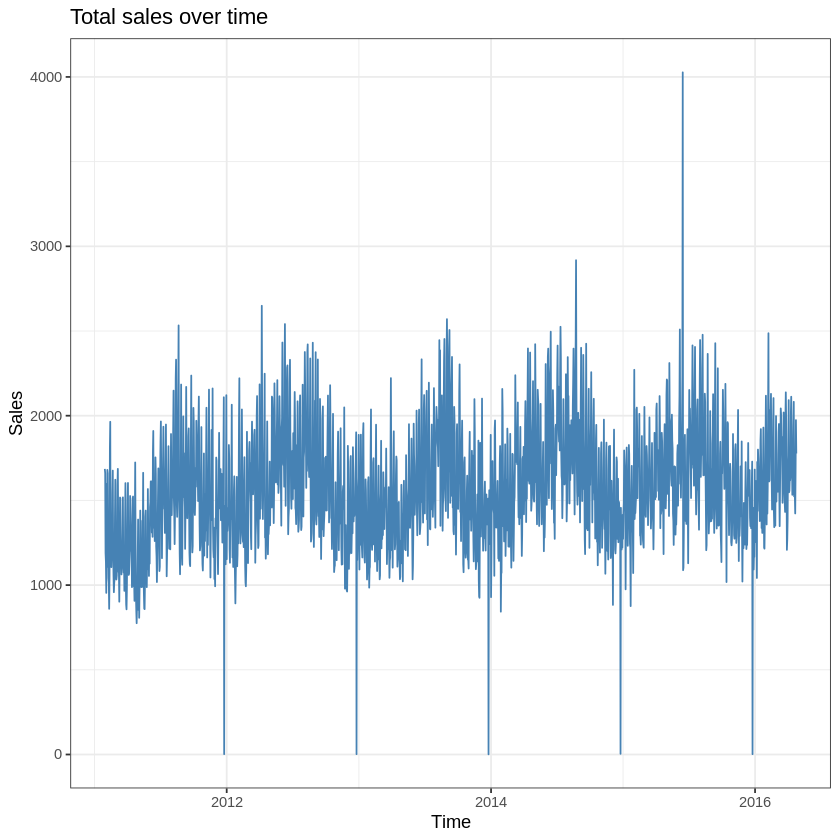

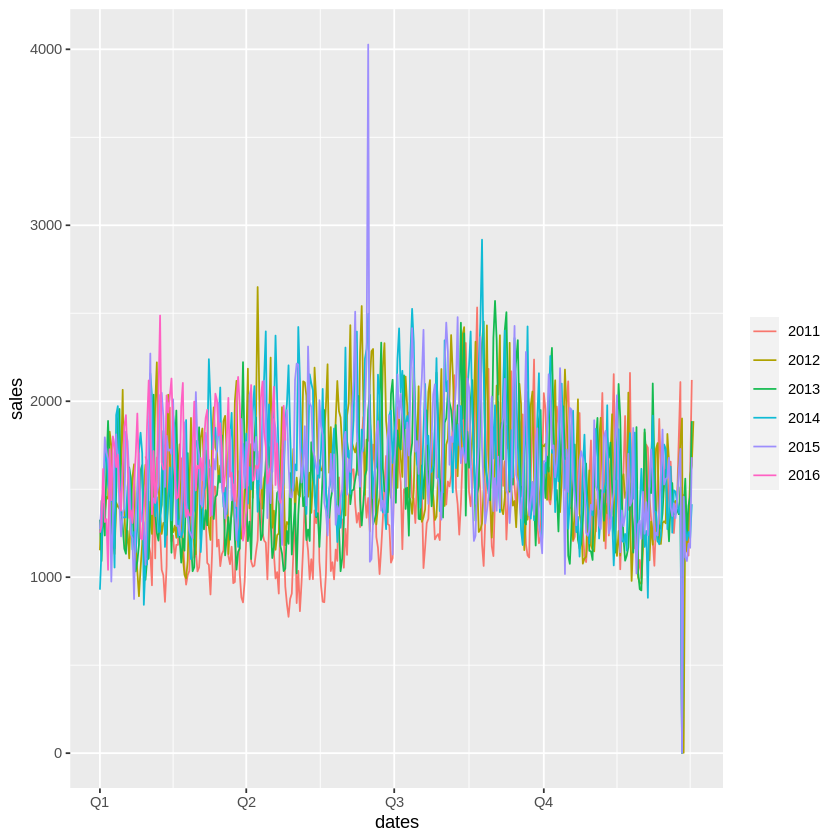

In [18]:
# calculating the total number of sales over time
foo <- sales_train %>% 
  summarise_at(vars(starts_with("d_")), sum) %>% 
  mutate(id = 1)

# transforming tabel
bar <- extract_ts(foo)

# plotting the total sales over time
bar %>% 
  ggplot(aes(dates, sales)) +
  geom_line(col = "steelblue") +
  labs(x = "Time", 
       y = "Sales", 
       title = "Total sales over time")+
  theme_bw()

gg_season(as_tsibble(bar))


`summarise()` has grouped output by 'wday', 'month'. You can override using the `.groups` argument.



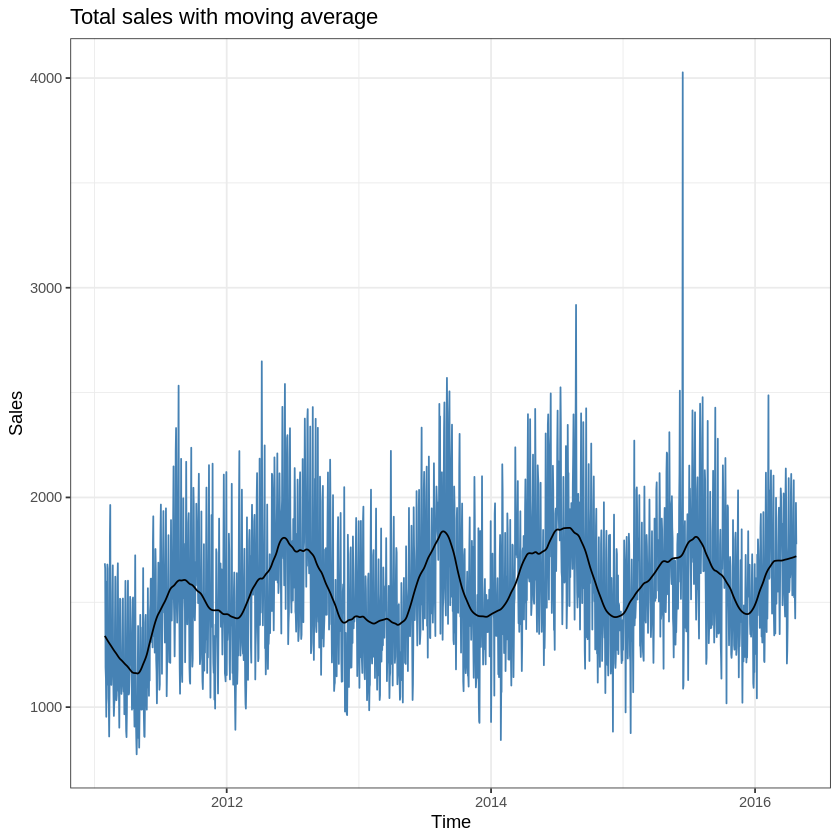

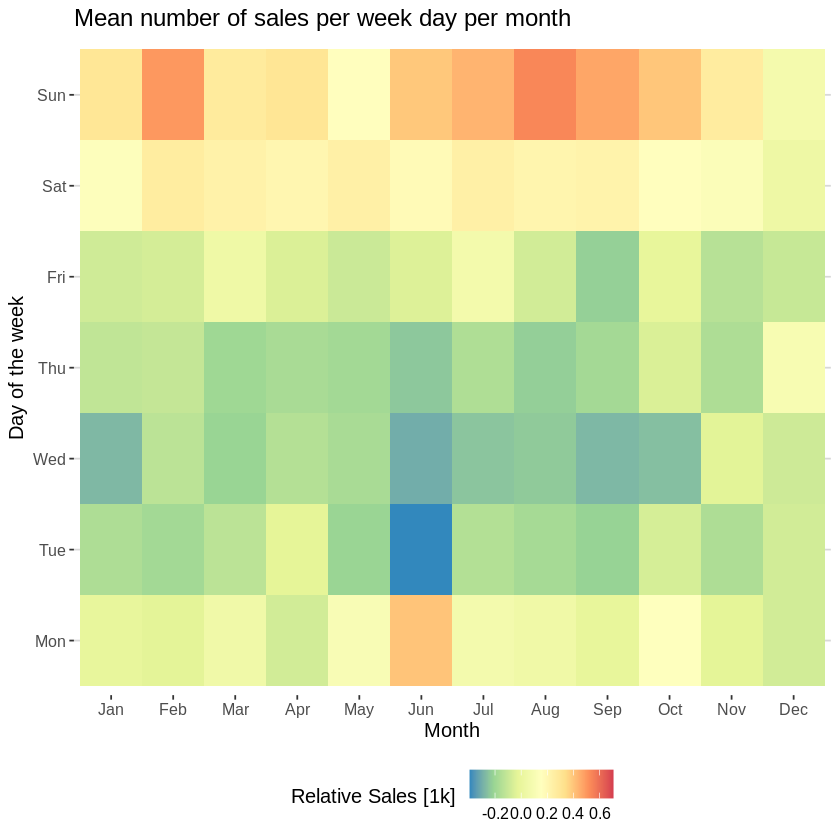

In [19]:
# calculating the total number of sales over time
foo <- sales_train %>% 
  summarise_at(vars(starts_with("d_")), sum) %>% 
  mutate(id = 1)

# transforming tabel
bar <- extract_ts(foo) %>% 
  filter(!str_detect(as.character(dates), "-12-25"))

# creating an moving average 
window = 0.05
loess_all <- predict(loess(bar$sales ~ as.integer(bar$dates - min(bar$dates)) + 1, span = window, degree = 1))

bar <- bar %>% 
  mutate(loess = loess_all) %>% 
  mutate(sales_rel = sales - loess)

# plotting the total sales with MA
bar %>% 
  ggplot(aes(dates, sales)) +
  geom_line(col = "steelblue") +
  geom_line(aes(dates, loess), col = "black") +
theme(text = element_text(size=35))+
  theme_bw() +
  labs(x = "Time", 
       y = "Sales", 
       title = "Total sales with moving average")



# plotting the day/month head map
bar %>% 
  mutate(wday = wday(dates, label = TRUE, week_start = 1),
         month = month(dates, label = TRUE),
         year = year(dates)) %>% 
  group_by(wday, month, year) %>% 
  summarise(sales = mean(sales_rel)/1e3) %>%
  ggplot(aes(month, wday, fill = sales)) +
  geom_tile() +
  labs(x = "Month", 
       y = "Day of the week",
       title = "Mean number of sales per week day per month", 
       fill = "Relative Sales [1k]") +
  scale_fill_distiller(palette = "Spectral") +
  theme_hc()


`summarise()` has grouped output by 'wday'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'month'. You can override using the `.groups` argument.



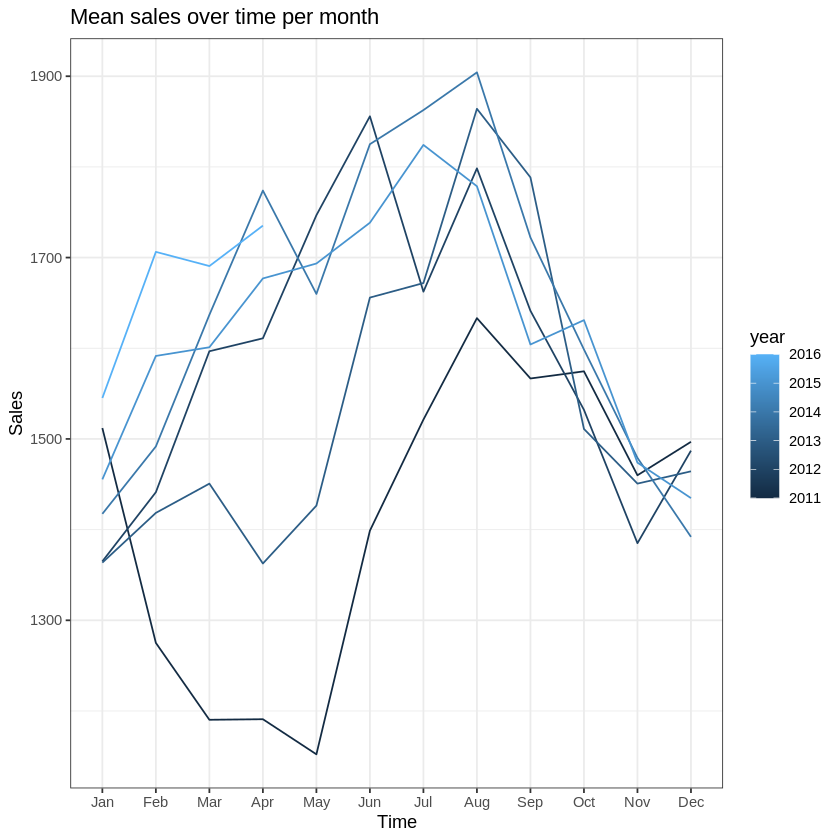

In [20]:
# calculating the total number of sales over time
foo <- sales_train %>% 
  summarise_at(vars(starts_with("d_")), sum) %>% 
  mutate(id = 1)

# transforming tabel
bar <- extract_ts(foo) %>% 
  filter(!str_detect(as.character(dates), "-12-25"))


# grouping by mean week
weekly <- bar %>% 
  mutate(wday = wday(dates, label = TRUE, week_start = 1),
         year = year(dates)) %>% 
  group_by(wday, year) %>% 
  summarise(sales = mean(sales))

# grouping by mean month
monthly <- bar %>% 
  mutate(month = month(dates, label = TRUE),
         year = year(dates)) %>% 
  group_by(month, year) %>% 
  summarise(sales = mean(sales))

# plotting the weekly means
plot_3 <- weekly %>% 
    ggplot(aes(x=wday, y=sales, col = year, group=year))+
    geom_line()+
    labs(x = "Time", 
         y = "Sales", 
         title = "Mean sales over time per weekday")+
    theme_bw()

# plotting the monthly means
monthly %>% 
    ggplot(aes(x=month, y=sales, col = year, group=year))+
    geom_line()+
    labs(x = "Time", 
         y = "Sales", 
         title = "Mean sales over time per month")+
    theme_bw()

In [21]:
weekly <- bar %>% 
  mutate(wday = wday(dates, label = TRUE, week_start = 1),
         month = month(dates, label = TRUE),
         year = year(dates)) %>% 
  group_by(wday, month, year) %>% 
  summarise(sales = sum(sales))

`summarise()` has grouped output by 'wday', 'month'. You can override using the `.groups` argument.



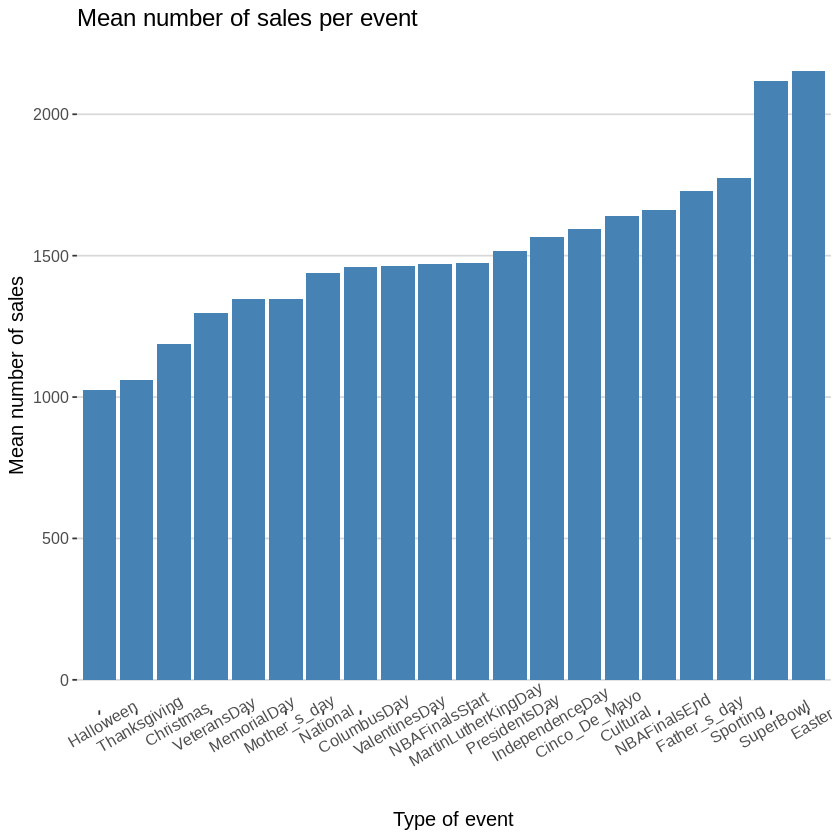

In [22]:
bar_chart <- read.csv('bar_data.csv', sep =';')

ggplot(bar_chart, aes(x=reorder(Religious,X1539), X1539)) +
  geom_bar(stat = "identity", fill='steelblue') +theme_hc()+
  theme(axis.text.x = element_text(angle = 30))+
    labs(x = "Type of event", 
       y = "Mean number of sales", 
       title = "Mean number of sales per event")



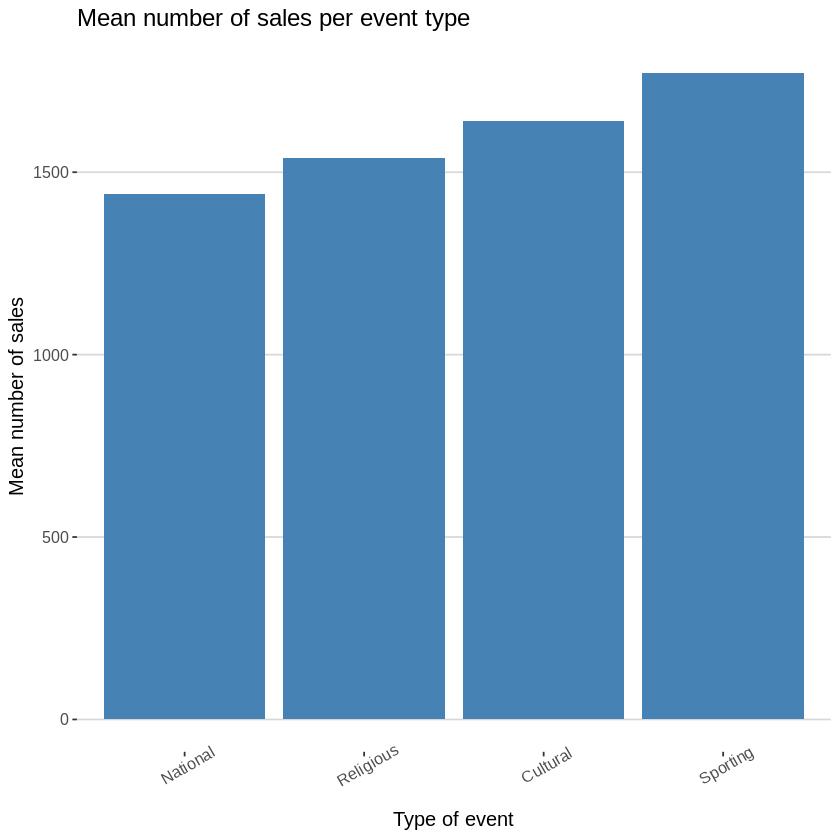

In [23]:
bar_chart_2 <- read.csv('bar_data_2.csv', sep =';')
bar_chart_2 <- bar_chart_2[1:4, ]

ggplot(bar_chart_2, aes(x=reorder(type,mean), mean)) +
  geom_bar(stat = "identity", fill='steelblue') +theme_hc()+
  theme(axis.text.x = element_text(angle = 30))+
    labs(x = "Type of event", 
       y = "Mean number of sales", 
       title = "Mean number of sales per event type")



In [24]:
acc <- read_csv('acc_score_ar_ets.csv')
acc_base <- read_csv('acc_score_baseline.csv')

Rows: 1646 Columns: 11

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): .model, id, .type
dbl (8): ME, RMSE, MAE, MPE, MAPE, MASE, RMSSE, ACF1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 3292 Columns: 11

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): .model, id, .type
dbl (8): ME, RMSE, MAE, MPE, MAPE, MASE, RMSSE, ACF1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



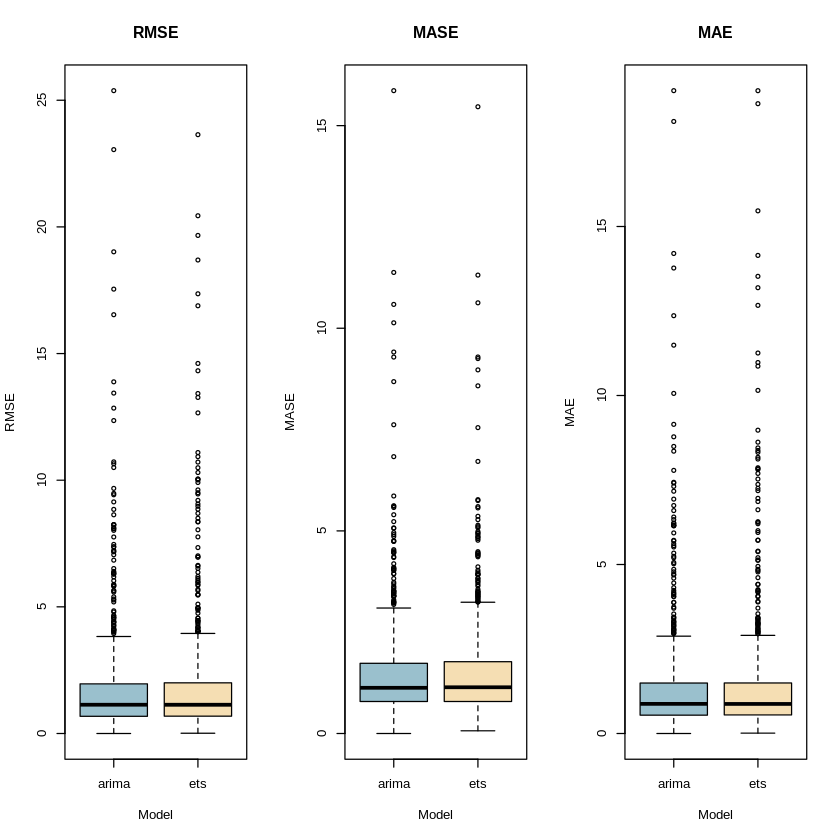

In [25]:
par(mfrow=c(1,3))
plot_1<- boxplot(RMSE~.model, data=acc,
       col=c('lightblue3', 'wheat'),
        xlab="Model", 
        main = "RMSE")

plot_2<- boxplot(MASE~.model, data=acc,
       col=c('lightblue3', 'wheat'),
        xlab="Model", 
        main = "MASE")

plot_3<- boxplot(MAE~.model, data=acc,
       col=c('lightblue3', 'wheat'),
        xlab="Model", 
        main = "MAE")

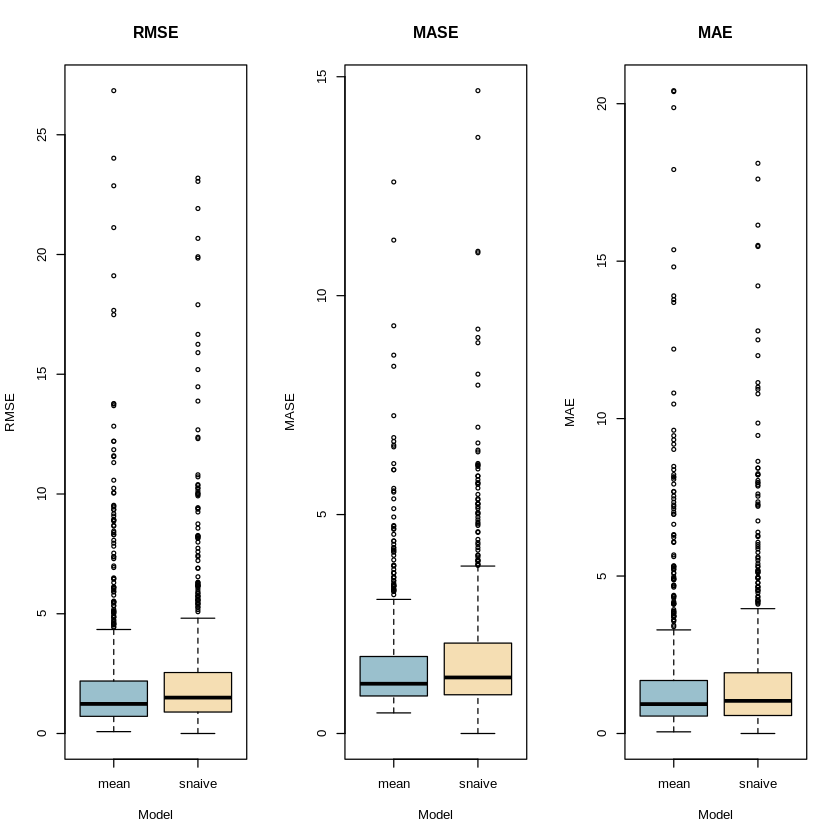

In [26]:
acc_base <- acc_base  %>% filter(.model == 'mean' | .model == 'snaive')

par(mfrow=c(1,3))
plot_1<- boxplot(RMSE~.model, data=acc_base,
       col=c('lightblue3', 'wheat'),
        xlab="Model", 
        main = "RMSE")

plot_2<- boxplot(MASE~.model, data=acc_base,
       col=c('lightblue3', 'wheat'),
        xlab="Model", 
        main = "MASE")

plot_3<- boxplot(MAE~.model, data=acc_base,
       col=c('lightblue3', 'wheat'),
        xlab="Model", 
        main = "MAE")